In [42]:
import pandas as pd 
import numpy as np 
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from torchvision.io import read_image
import warnings

# Deep Neural Networks Laboratory

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset Preparation

This time, instead of using Custom Datasets, we will download the dataset directly from Torch.

In [44]:
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

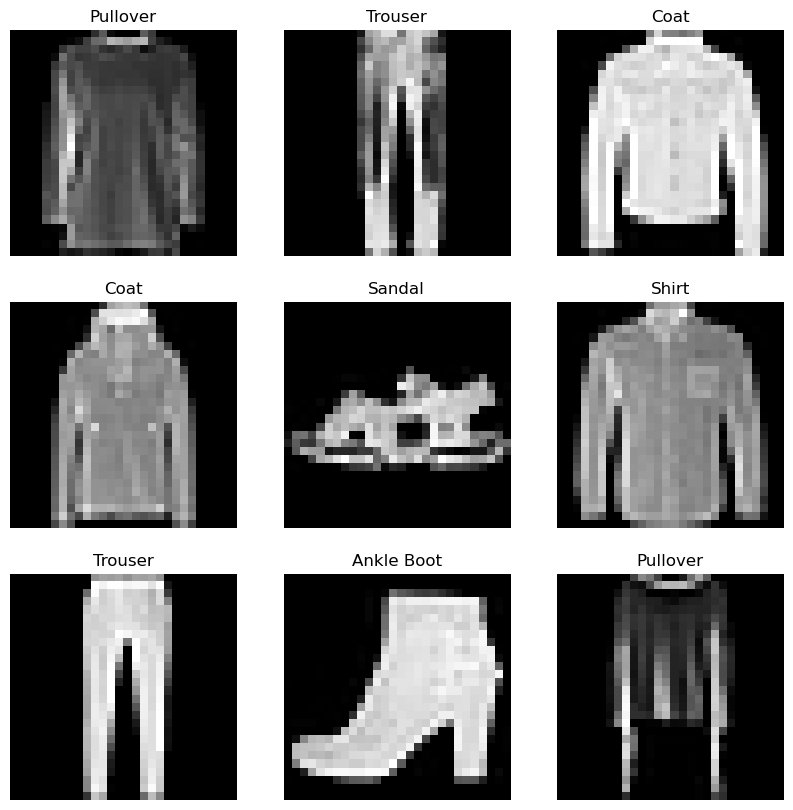

In [45]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [46]:
batch_size = 128

train_dataloader= DataLoader(train_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Images in the Fashion MNIST dataset are 28x28 single channel images:

In [47]:
image, _ = train_data[sample_idx]
image.shape

torch.Size([1, 28, 28])

If they were colored, they would probably be RGB-coded, which implies they would have had 3 channels instead of 1, making them 3x28x28 tensors.

##  Basics of a Convolutional Layer

When dealing with Convolutional Neural Networks, the most challenging task is correctly structuring your net such that the input is correctly processed in various shapes and dimensions.

The images from MNIST are 1x28x28 tensors, so gray scaled 28x28 images. Here is an example:

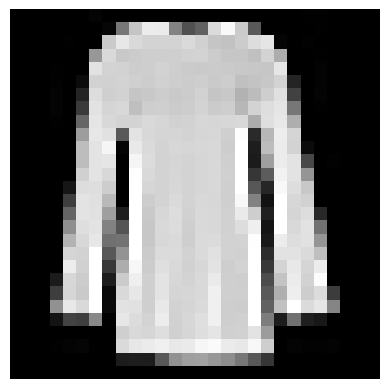

In [48]:
sample_idx = torch.randint(len(train_data), size = (1,)).item()
image, label = train_data[sample_idx]
figure.add_subplot(rows, cols, i)
plt.axis('off')
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [49]:
image.shape

torch.Size([1, 28, 28])

In [50]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0039,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0235,
          0.4667, 0.7725, 0.9255, 0.9216, 0.5137, 0.3216, 0.3843, 0.8588,
          0.9765, 0.7961, 0.3529, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.7922,
          0.9059, 0.8510, 0.8314, 0.8314, 0.8275, 0.8549, 0.8196, 0.7725,
          0.7608, 0.8000, 0.8667, 0.8980, 0.0196, 0.0000, 0.0078, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5922, 0.8510,
          0.7843, 0.8000, 0.8078, 0.8078, 0.8118, 0.8235, 0.8275, 0.8000,
          0.7765, 0.7765, 0.7529, 0.8314, 0.6784, 0.0000,

Imagine we want to add a Convolutional Layer directly on this input. We will select in_channels = 1, because as we mentioned, MNIST images are grayscaled, so they only have 1 channel.

We then select the kernel size, 4 in this case.

We can then select how many output channels we want. It's good practice in a CNN to apply multiple kernels, and therefore use multiple out_channels.

![images/kernel.png](images/kernel.png) 

When developing a Convolutional Layer, you have to remember:
1. The Kernel size (see above)
2. The stride 
3. The padding
4. The number of out channels

![images/stride.png](images/stride.png) 

Padding:

![images/padding.png](images/padding.png) 

Lastly, the output channels are simply the number of kernels we use.

Let's have a look at an example Convolutional layer with:
1. Kernel size 4x4
2. stride = 1
3. No padding
4. 3 output channels

In [51]:
test_convolutional_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=4)


x = next(train_dataloader.__iter__())[0]
print('Shape of x:', x.shape)
## The shape will be 128, 1, 28, 28 because we have 128 images in a batch, 1 channel, and 28x28 pixels

x2 = test_convolutional_layer(x)
print('Shape of x2:', x2.shape)
## The shape will be 128, 3, 25, 25 because we have 128 images in a batch, 3 channels, and 25x25 pixels

Shape of x: torch.Size([128, 1, 28, 28])
Shape of x2: torch.Size([128, 3, 25, 25])


Let's take a deeper look at what is happening: we represent a 28x28 image with its 4x4 kernel.

![images/kernel_1.png](images/kernel_1.png) 

Now, since we specified stride = 1, the kernel only moves one square to the right.

![images/kernel_2.png](images/kernel_2.png) 

This can happen a total of 25 times before the 4x4 kernel reaches the rightmost limit of the image. 

![images/kernel_3.png](images/kernel_3.png) 

Since we selected no padding, it means that the kernel can no longer be applied starting from Pixel 26, or it would go out of bounds.

This means that we obtain 25 values from each application of the kernel.
The same thing goes for the vertical applications, so for each image we obtain 25x25 values, which is the shape of the output after the convolutional layer.

Since we have 3 output channels, we are applying 3 kernels, so the final shape will be 

Elements in a batch (128) x 3 x 25 x 25

In [52]:
x2.shape

torch.Size([128, 3, 25, 25])

In order to compute the shape of the input after a convolutional layer, you can use the following formula:


![images/output_size.png](images/output_size.png) 

Let's apply it to the previous example.

Input Size = 28

Kernel size = 4

Padding = 0

Stride = 1

Output Size = 24 + 1 = 25

## Basics of Max Pooling

Max pooling takes the max out of an area of values. The area is usually squared, and its purpose is to reduce the dimensionality of a tensor. 

![images/max_pooling.png](images/max_pooling.png) 

The formula for computing the size after a max pooling layer is the same as before.

Imagine we have a MaxPool with kernel size 2, stride 2 and no padding. 

The input is the tensor obtained from the previous convolutional layer (so the shape is 3x25x25).

The output will be of shape:

(25 - 2)/2 + 1 = 12 as we take the lower int.

So the output will be of shape 3x12x12.

In [53]:
maxpool_test = nn.MaxPool2d(kernel_size=2,stride=2)

x3 = maxpool_test(x2)

print('Shape of x3:', x3.shape)

Shape of x3: torch.Size([128, 3, 12, 12])


## Building a Convolutional Neural Network

In [54]:
class Net(nn.Module):
    def __init__(self, num_classes=len(labels_map)):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(125, 200)  
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, num_classes)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [55]:
net.to(device)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=125, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [56]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 1000 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  # torch save model with torch.save()
  torch.save({'model_weights': model.state_dict()}, 'model.pt')

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return (100*correct)

In [57]:
learning_rate = 1e-4
epochs = 40

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

accuracies = []
losses = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, net, loss_fn, optimizer)
  accuracies.append(test_loop(test_dataloader, net, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 2.304446  [  128/60000]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.938239 

Epoch 2
-------------------------------
loss: 0.918125  [  128/60000]
Test Error: 
 Accuracy: 69.9%, Avg loss: 0.798200 

Epoch 3
-------------------------------
loss: 0.731375  [  128/60000]
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.736372 

Epoch 4
-------------------------------
loss: 0.658793  [  128/60000]
Test Error: 
 Accuracy: 73.5%, Avg loss: 0.696480 

Epoch 5
-------------------------------
loss: 0.619199  [  128/60000]
Test Error: 
 Accuracy: 74.9%, Avg loss: 0.665901 

Epoch 6
-------------------------------
loss: 0.592748  [  128/60000]
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.641603 

Epoch 7
-------------------------------
loss: 0.570732  [  128/60000]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.621244 

Epoch 8
-------------------------------
loss: 0.548556  [  128/60000]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.605154 

Epoch 9
----------------

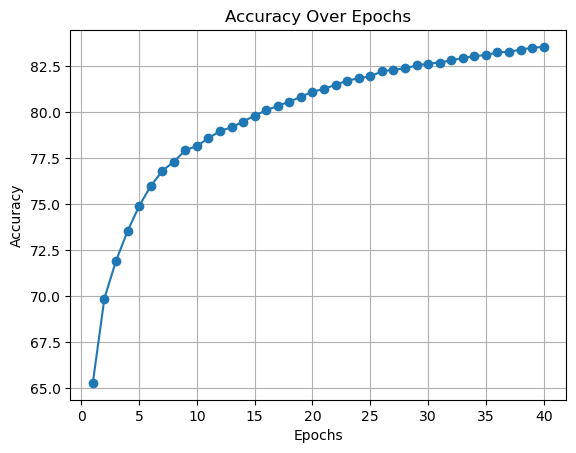

In [59]:
import matplotlib.pyplot as plt

epochs = range(1, len(accuracies) + 1)

plt.plot(epochs, accuracies, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

In [60]:
labels_map

{0: 'T-shirt',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle Boot'}

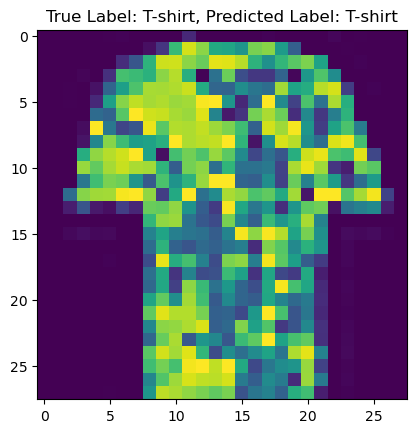

In [61]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

net.eval()

sample_index = random.randint(0, len(test_data) - 1)  
sample_image, true_label = test_data[sample_index]

sample_image = sample_image.unsqueeze(0).to(device)

with torch.no_grad():
    model_output = net(sample_image)

predicted_label = torch.argmax(model_output, dim=1).item()

image = transforms.ToPILImage()(sample_image.squeeze(0))

# Display the image and prediction
plt.imshow(image)
plt.title(f'True Label: {labels_map[true_label]}, Predicted Label: {labels_map[predicted_label]}')
plt.show()